In [1]:
import os
import gc
import math
import random
from collections import defaultdict

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from torch.optim import Adam
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import classification_report, f1_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = '../data/Module_6_Lecture_1_CoNLL2003/'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def load_sentences(filepath):
    final = []
    sentences = []
    with open(filepath, 'r') as f:
        for line in f.readlines():
            if (line == ('-DOCSTART- -X- -X- O\n') or line == '\n'):
                if len(sentences) > 0:
                    final.append(sentences)
                    sentences = []
            else:
                l = line.split(' ')
                sentences.append((l[0], l[3].strip('\n')))
    return final

In [4]:
train_sents = load_sentences(data_path + 'train.txt')
test_sents = load_sentences(data_path + 'test.txt')
val_sents = load_sentences(data_path + 'valid.txt')

In [5]:
train_sents[:3]

[[('EU', 'B-ORG'),
  ('rejects', 'O'),
  ('German', 'B-MISC'),
  ('call', 'O'),
  ('to', 'O'),
  ('boycott', 'O'),
  ('British', 'B-MISC'),
  ('lamb', 'O'),
  ('.', 'O')],
 [('Peter', 'B-PER'), ('Blackburn', 'I-PER')],
 [('BRUSSELS', 'B-LOC'), ('1996-08-22', 'O')]]

In [6]:
ner_labels = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
id2label = {str(i): label for i, label in enumerate(ner_labels)}
label2id = {value: int(key) for key, value in id2label.items()}

In [7]:
def get_df(samples):
    df,label = [], []
    for lines in samples:
        cur_line, cur_label = list(zip(*lines))
        df.append(list(cur_line))
        label.append([label2id[i] for i in cur_label])
    return {'text':df, 'label':label}

In [8]:
train_df = get_df(train_sents)
test_df = get_df(test_sents)
val_df = get_df(val_sents)

In [9]:
word_dict = defaultdict(int)

for line in train_df['text']:
    for word in line:
        word_dict[word] += 1

lower_freq_word = []
for k,v in word_dict.items():
    if v < 2:
        lower_freq_word.append(k)

for word in lower_freq_word:
    del word_dict[word]
    
word_dict['<UNK>'] = -1
word_dict['<PAD>'] = -2

word2id = {}

for idx, word in enumerate(word_dict.keys()):
    word2id[word] = idx

In [10]:
def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w in to_ix.keys():
            idxs.append(to_ix[w])
        else:
            idxs.append(to_ix['<UNK>'])
    return idxs

In [11]:
class CoNLLDataset(Dataset):
    def __init__(self, df):
        self.texts = df['text']
        self.labels = df['label']

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_sequence(self.texts[item], word2id)
        label = self.labels[item]
        return {
            'input_ids': inputs,
            'labels': label
        }

class Collate:
    def __init__(self, train):
        self.train = train

    def __call__(self, batch):
        output = dict()
        output["input_ids"] = [sample["input_ids"] for sample in batch]
        if self.train:
            output["labels"] = [sample["labels"] for sample in batch]

        # calculate max token length of this batch
        batch_max = max([len(ids) for ids in output["input_ids"]])

        # add padding

        output["input_ids"] = [s + (batch_max - len(s)) * [word2id['<PAD>']] for s in output["input_ids"]]
        if self.train:
            output['labels'] = [s + (batch_max - len(s)) * [-100] for s in output["labels"]]

        # convert to tensors
        output["input_ids"] = torch.tensor(output["input_ids"], dtype=torch.long)
        if self.train:
            output["labels"] = torch.tensor(output["labels"], dtype=torch.long)

        return output
    
collate_fn = Collate(True)  

In [12]:
class BiLSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super(BiLSTMTagger, self).__init__()
        
        # 1. Embedding Layer
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embeddings = nn.Embedding.from_pretrained(embeddings)#, freeze=True)
        
        # 2. LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=3, batch_first=True)

        # 3. Dense Layer
        self.fc = nn.Linear(2*hidden_dim, output_size)
        
    def forward(self, batch_text):

        embeddings = self.embeddings(batch_text)
        
        lstm_output, _ = self.lstm(embeddings) 

        logits = self.fc(lstm_output)
        return logits

In [13]:
def remove_predictions_for_masked_items(predicted_labels, correct_labels): 

    predicted_labels_without_mask = []
    correct_labels_without_mask = []
        
    for p, c in zip(predicted_labels, correct_labels):
        if c > 0:
            predicted_labels_without_mask.append(p)
            correct_labels_without_mask.append(c)
            
    return predicted_labels_without_mask, correct_labels_without_mask


def train(model, train_loader, val_loader, batch_size, max_epochs, num_batches, patience, output_path):
    criterion = nn.CrossEntropyLoss(ignore_index=-100)  # we mask the <pad> labels
    optimizer = Adam(model.parameters())

    train_f_score_history = []
    dev_f_score_history = []
    no_improvement = 0
    for epoch in range(max_epochs):

        total_loss = 0
        predictions, correct = [], []
        model.train()
        for batch in tqdm(train_loader, total=num_batches, desc=f"Epoch {epoch}"):
            
            cur_batch_size, text_length = batch['input_ids'].shape
            
            pred = model(batch['input_ids'].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch['labels'].to(device).view(cur_batch_size*text_length)
            
            loss = criterion(pred, gold)
            
            total_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, pred_indices = torch.max(pred, 1)
            
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch['labels'].view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        train_score = f1_score(correct, predictions, average="macro")
        train_f_score_history.append(train_score)
            
        print("Total training loss:", total_loss)
        print("Training Macro F1:", train_score)
        
        total_loss = 0
        predictions, correct = [], []
        
        model.eval()
        with torch.no_grad():
            for batch in val_loader:

                cur_batch_size, text_length = batch['input_ids'].shape
                
                pred = model(batch['input_ids'].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
                gold = batch['labels'].to(device).view(cur_batch_size*text_length)
                
                loss = criterion(pred, gold)
                total_loss += loss.item()

                _, pred_indices = torch.max(pred, 1)
                predicted_labels = list(pred_indices.cpu().numpy())
                correct_labels = list(batch['labels'].view(cur_batch_size*text_length).numpy())

                predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                       correct_labels)

                predictions += predicted_labels
                correct += correct_labels

        dev_score = f1_score(correct, predictions, average="macro")
            
        print("Total validation loss:", total_loss)
        print("Validation Macro F1:", dev_score)
        
        dev_f = dev_score
        if len(dev_f_score_history) > patience and dev_f < max(dev_f_score_history):
            no_improvement += 1

        elif len(dev_f_score_history) == 0 or dev_f > max(dev_f_score_history):
            print("Saving model.")
            torch.save(model, output_path)
            no_improvement = 0
            
        if no_improvement > patience:
            print("Validation F-score does not improve anymore. Stop training.")
            dev_f_score_history.append(dev_f)
            break
            
        dev_f_score_history.append(dev_f)
        
    return train_f_score_history, dev_f_score_history

In [14]:
def test(model, test_iter, batch_size, labels, target_names): 
    total_loss = 0
    predictions, correct = [], []
    
    model.eval()
    with torch.no_grad():    
    
        for batch in test_iter:

            cur_batch_size, text_length = batch['input_ids'].shape

            pred = model(batch['input_ids'].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch['labels'].to(device).view(cur_batch_size*text_length)

            _, pred_indices = torch.max(pred, 1)
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch['labels'].view(cur_batch_size*text_length).numpy())



            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)

            predictions += predicted_labels
            correct += correct_labels
    
    print(classification_report(correct, predictions, labels=labels, target_names=target_names))

In [15]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 64
NUM_CLASSES = len(id2label)
MAX_EPOCHS = 50
PATIENCE = 3
BATCH_SIZE = 32
VOCAB_SIZE = len(word2id)
OUTPUT_PATH = "/tmp/bilstmtagger"
num_batches = math.ceil(len(train_df) / BATCH_SIZE)

In [16]:
train_dataset = CoNLLDataset(train_df)
val_dataset = CoNLLDataset(val_df)
test_dataset = CoNLLDataset(test_df)

In [17]:
train_loader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn,
                              num_workers=4,
                              pin_memory=True,
                              drop_last=False)

val_loader = DataLoader(val_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn,
                              num_workers=4,
                              pin_memory=True,
                              drop_last=False)

test_loader = DataLoader(test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn,
                              num_workers=4,
                              pin_memory=True,
                              drop_last=False)

In [18]:
tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES) 
tagger

BiLSTMTagger(
  (embeddings): Embedding(11986, 100)
  (lstm): LSTM(100, 64, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=9, bias=True)
)

In [19]:
train_f, dev_f = train(tagger.to(device), train_loader, val_loader, BATCH_SIZE, MAX_EPOCHS, 
                       num_batches, PATIENCE, OUTPUT_PATH)

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 338.05778880417347
Training Macro F1: 0.029850534784372544
Total validation loss: 52.80369229614735
Validation Macro F1: 0.15888431476923076
Saving model.


Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 157.69785359874368
Training Macro F1: 0.4028023452748979
Total validation loss: 28.38935230486095
Validation Macro F1: 0.47907729593486387
Saving model.


Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 85.81610597623512
Training Macro F1: 0.6283749725866336
Total validation loss: 21.03705334244296
Validation Macro F1: 0.6445286423602512
Saving model.


Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 52.59428001777269
Training Macro F1: 0.7292396213060545
Total validation loss: 17.833247248083353
Validation Macro F1: 0.6915401395464842
Saving model.


Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 33.93036324484274
Training Macro F1: 0.7862612677844731
Total validation loss: 16.81808718224056
Validation Macro F1: 0.7129063809637389
Saving model.


Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 22.999371595680714
Training Macro F1: 0.822347934951575
Total validation loss: 16.973952096770518
Validation Macro F1: 0.714787931687375
Saving model.


Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 15.918071352876723
Training Macro F1: 0.8451432247360013
Total validation loss: 18.107751118426677
Validation Macro F1: 0.7174530603447911
Saving model.


Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 11.740883170219604
Training Macro F1: 0.8573486369548743
Total validation loss: 20.671968238137197
Validation Macro F1: 0.7169977445601403


Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 8.939718780471594
Training Macro F1: 0.8668117995292963
Total validation loss: 20.047128543577855
Validation Macro F1: 0.7199212493277352
Saving model.


Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 6.942469063884346
Training Macro F1: 0.8716885141246884
Total validation loss: 20.25707124666951
Validation Macro F1: 0.728647589173789
Saving model.


Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 5.956361190590542
Training Macro F1: 0.8736432327608044
Total validation loss: 20.771715039998526
Validation Macro F1: 0.7298283068129906
Saving model.


Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 5.389634548468166
Training Macro F1: 0.8766733696668421
Total validation loss: 22.15112502806005
Validation Macro F1: 0.7255828240179866


Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 4.25818737391819
Training Macro F1: 0.8786361158717111
Total validation loss: 22.71905472677463
Validation Macro F1: 0.7256896105377725


Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 3.7578197256370913
Training Macro F1: 0.8801709634813502
Total validation loss: 22.738196911508567
Validation Macro F1: 0.7315885766438814
Saving model.


Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 2.5411142347802524
Training Macro F1: 0.8839959222235443
Total validation loss: 24.557404159884754
Validation Macro F1: 0.7261746147908493


Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 1.9257397375149594
Training Macro F1: 0.8852321721356513
Total validation loss: 24.948571853474277
Validation Macro F1: 0.7297803855590437


Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 1.8256175897768117
Training Macro F1: 0.8850698547897238
Total validation loss: 24.47779353572696
Validation Macro F1: 0.7316211614325002
Saving model.


Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 1.7314149817593716
Training Macro F1: 0.8855104932677124
Total validation loss: 25.820302798892953
Validation Macro F1: 0.7328620465463237
Saving model.


Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 2.40282726318037
Training Macro F1: 0.8833111447718714
Total validation loss: 25.030858986636304
Validation Macro F1: 0.7345651816735229
Saving model.


Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 3.373094162599955
Training Macro F1: 0.8803619902991399
Total validation loss: 24.685203541695955
Validation Macro F1: 0.7276323132773954


Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 2.7041560166599083
Training Macro F1: 0.8823957322670335
Total validation loss: 25.657489695640834
Validation Macro F1: 0.7290910969154748


Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 1.3506830804344645
Training Macro F1: 0.8863552934681872
Total validation loss: 27.3473722807812
Validation Macro F1: 0.7338447639417036


Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 0.7844546082924353
Training Macro F1: 0.8873819716645233
Total validation loss: 27.309885095215577
Validation Macro F1: 0.7359163128108963
Saving model.


Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 0.6946804611561674
Training Macro F1: 0.8878056123123409
Total validation loss: 28.5092304397549
Validation Macro F1: 0.7328845190019084


Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 0.6408728347914803
Training Macro F1: 0.8879104884969947
Total validation loss: 28.08802764108168
Validation Macro F1: 0.7365017702073496
Saving model.


Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 1.1239040709147048
Training Macro F1: 0.8861326997992928
Total validation loss: 28.9653683378383
Validation Macro F1: 0.7222982350765048


Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 4.598749989278076
Training Macro F1: 0.8741228678437177
Total validation loss: 25.849350801407127
Validation Macro F1: 0.726686692804506


Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 2.337516318530106
Training Macro F1: 0.88403981957758
Total validation loss: 25.617120698421786
Validation Macro F1: 0.7297238736636488


Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 1.044020002716934
Training Macro F1: 0.8866711300834349
Total validation loss: 27.063435720003326
Validation Macro F1: 0.7313534862754345
Validation F-score does not improve anymore. Stop training.


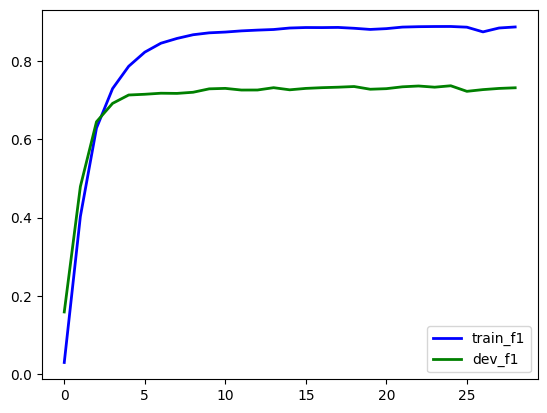

In [20]:
df = pd.DataFrame({'epochs': range(0,len(train_f)), 
                  'train_f1': train_f, 
                   'dev_f1': dev_f})

plt.plot('epochs', 'train_f1', data=df, color='blue', linewidth=2)
plt.plot('epochs', 'dev_f1', data=df, color='green', linewidth=2)
plt.legend()
plt.show()

In [21]:
tagger = torch.load(OUTPUT_PATH)

In [22]:
labels = list(label2id.keys())[1:]
label_idxs = list(label2id.values())[1:]

test(tagger, test_loader, BATCH_SIZE, labels = label_idxs, target_names = labels)

              precision    recall  f1-score   support

       B-PER       0.87      0.70      0.77      1617
       I-PER       0.91      0.77      0.83      1156
       B-ORG       0.83      0.66      0.73      1661
       I-ORG       0.85      0.69      0.76       835
       B-LOC       0.91      0.77      0.83      1668
       I-LOC       0.83      0.61      0.70       257
      B-MISC       0.73      0.69      0.71       702
      I-MISC       0.70      0.60      0.65       216

   micro avg       0.86      0.71      0.77      8112
   macro avg       0.83      0.68      0.75      8112
weighted avg       0.86      0.71      0.77      8112

